In [26]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Load the dataset
url = r"D:\Computer science\Year 3\Project COM3001\The App\Models\week_approach_maskedID_timeseries.csv"
data = pd.read_csv(url)
print(data)

In [15]:
# Define the features and target
feature_columns = [
    'nr. sessions', 'nr. sessions.1', 'nr. sessions.2', 'nr. sessions.3', 'nr. sessions.4', 'nr. sessions.5', 'nr. sessions.6',
    'total km', 'total km.1', 'total km.2', 'total km.3', 'total km.4', 'total km.5', 'total km.6',
    'km Z3-4', 'km Z3-4.1', 'km Z3-4.2', 'km Z3-4.3', 'km Z3-4.4', 'km Z3-4.5', 'km Z3-4.6',
    'km Z5-T1-T2', 'km Z5-T1-T2.1', 'km Z5-T1-T2.2', 'km Z5-T1-T2.3', 'km Z5-T1-T2.4','km Z5-T1-T2.5', 'km Z5-T1-T2.6',
    'km sprinting', 'km sprinting.1', 'km sprinting.2', 'km sprinting.3', 'km sprinting.4', 'km sprinting.5', 'km sprinting.6', 
    'strength training', 'strength training.1', 'strength training.2', 'strength training.3', 'strength training.4', 'strength training.5', 'strength training.6',
    'hours alternative', 'hours alternative.1', 'hours alternative.2', 'hours alternative.3', 'hours alternative.4', 'hours alternative.5', 'hours alternative.6',
    'perceived exertion', 'perceived exertion.1', 'perceived exertion.2', 'perceived exertion.3', 'perceived exertion.4', 'perceived exertion.5', 'perceived exertion.6',
    'perceived trainingSuccess', 'perceived trainingSuccess.1', 'perceived trainingSuccess.2', 'perceived trainingSuccess.3', 'perceived trainingSuccess.4', 'perceived trainingSuccess.5', 'perceived trainingSuccess.6', 
    'perceived recovery', 'perceived recovery.1', 'perceived recovery.2', 'perceived recovery.3', 'perceived recovery.4', 'perceived recovery.5', 'perceived recovery.6'
    ]
target_column = 'injury'

# Extract features and target
X = data[feature_columns].values
Y = data[target_column].values

# Reshape X for LSTM input
sequence_length = 7  # 7 days
num_features = len(feature_columns) // sequence_length  # Number of features per day
X_LSTM = X.reshape(-1, sequence_length, num_features)
Y_LSTM = Y

# XGBOOST input
X_XGBOOST = X
Y_XGBOOST = Y

print(f"Shape of input for LSTM: {X_LSTM.shape}")  # (num_samples, 7, num_features)
print(f"Shape of input for XGBOOST: {X_XGBOOST.shape}")

Shape of input for LSTM: (42766, 7, 10)
Shape of input for XGBOOST: (42766, 70)


In [16]:
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, Y_LSTM, test_size=0.2, random_state=42)
X_train_BOOST, X_test_BOOST, Y_train_BOOST, Y_test_BOOST = train_test_split(X_XGBOOST, Y_XGBOOST, test_size=0.2, random_state=42)

583
42183


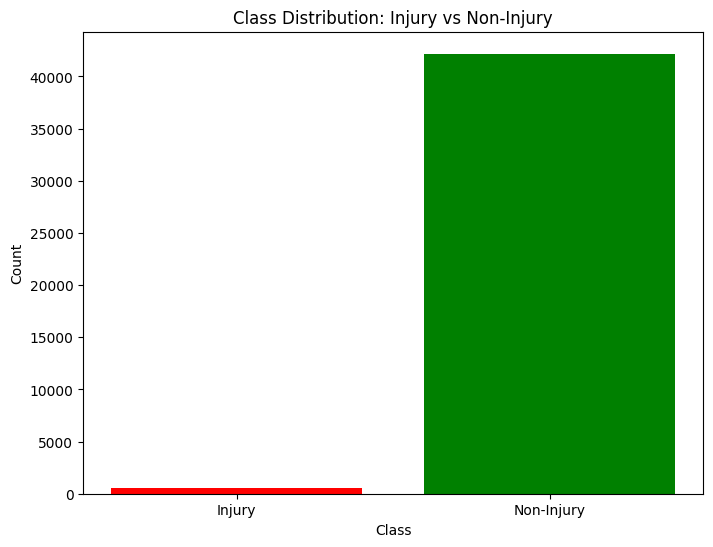

In [19]:
# It counts the first occurance as to the first variable
noninjury, injury = np.bincount(Y)
print(injury)
print(noninjury)

# Labels for the classes
labels = ['Injury', 'Non-Injury']
counts = [injury, noninjury]

# Plotting the bar chart
plt.figure(figsize=(8, 6))  # Set the size of the figure
plt.bar(labels, counts, color=['red', 'green'])  # Color for each class
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution: Injury vs Non-Injury')

# Display the plot
plt.show()


In [ ]:
# Define the model
model = Sequential()

model.add(LSTM(50, input_shape=(sequence_length, num_features)))  # Return sequences for stacked LSTM
model.add(Dropout(0.2))  # Increase dropout rate

# Add a Dense output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

# Print the model summary
model.summary()

c:\Users\ench0\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,251 (47.86 KB)

 Trainable params: 12,251 (47.86 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_LSTM, Y_train_LSTM,
    epochs=20,  # Number of training iterations
    batch_size=32,  # Number of samples per gradient update
    validation_data=(X_test_LSTM, Y_test_LSTM),  # Evaluate on the test set during training
    class_weight = {0:1,1:8} # treats instances of 1 as 8 instances
)


Epoch 1/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9837 - loss: 0.3864 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9860 - val_loss: 0.1640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9866 - loss: 0.3440 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9860 - val_loss: 0.1465 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9875 - loss: 0.3199 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9860 - val_loss: 0.1472 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9859 - loss: 0.3559 - precision: 0.6144 - recall: 0.0023 - val_accuracy: 0.9830 - val_loss: 0.1900 - val_precision: 0.0370 - val_recall: 0.0083
Epoch 5/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9860 - loss: 0.3425 - precision: 0.0

In [ ]:
loss, accuracy = model.evaluate(X_test_LSTM, Y_test_LSTM)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9858 - loss: 0.0769
Test Loss: 0.08036775141954422
Test Accuracy: 0.9850362539291382


In [ ]:
LSTMpredictions = model.predict(X_test_LSTM)

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [27]:
# Train an XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
model.fit(X_train_BOOST, Y_train_BOOST)

# Make predictions
predictions = model.predict(X_train_BOOST)

# Evaluate the model performance
accuracy = accuracy_score(Y_train_BOOST, predictions)
precision = precision_score(Y_train_BOOST, predictions)
recall = recall_score(Y_train_BOOST, predictions)
f1 = f1_score(Y_train_BOOST, predictions)
conf_matrix = confusion_matrix(Y_train_BOOST, predictions)

# Print results
print("Predictions:", predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Optional: Detailed classification report
print("\nClassification Report:\n", classification_report(Y_train_BOOST, predictions))

Predictions: [0 0 0 ... 0 0 0]
Accuracy: 0.998216999883082
Precision: 1.0
Recall: 0.8682505399568035
F1 Score: 0.9294797687861271
Confusion Matrix:
 [[33749     0]
 [   61   402]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     33749
           1       1.00      0.87      0.93       463

    accuracy                           1.00     34212
   macro avg       1.00      0.93      0.96     34212
weighted avg       1.00      1.00      1.00     34212

